In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## DataLoad

In [2]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')
ds2 = fred.get_series('DGS2').fillna(method='pad')
tb3 = fred.get_series('DTB3').fillna(method='pad')
dff = fred.get_series('DFF').fillna(method='pad')

In [3]:
## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div']
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20
df_ref['DGS2'] = ds2
df_ref['DTB3'] = tb3

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, '^DJI', 'Div')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS2', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'DGS2', 'DTB3', log_diff=False)
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']]
_cols = ['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold']
df_ref[_cols] = df_ref[_cols]/df_ref[_cols].iloc[0]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']
df_ref['Cash'] = (df_ref['DTB3']/100 * 1/252 + 1).cumprod()

[*********************100%%**********************]  4 of 4 completed


0.9187999966055177
0.8698779253276527
0.8863131456136707
1.0153117579739583
0.6628002072029059
0.7091581100811436
0.9953424146502148


In [4]:
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

## Anal

In [5]:
## 프로젝트마다 필요한 데이터
tickers = ['S&P500']
df_imp = df_ref[tickers].copy()

In [6]:
df_imp_m = df_imp.resample('M').first()

In [7]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.signal import savgol_filter

In [8]:
df_decomp = np.log(df_imp_m)
cycle, trend = hpfilter(df_decomp[tickers[0]], lamb=129600*1024)
df_decomp['Trend'] = trend
df_decomp['Cycle'] = cycle
filtered_df_decomp = savgol_filter(df_decomp['Cycle'], window_length=60, polyorder=2, axis=0)
cycle_df = pd.DataFrame(filtered_df_decomp, index=df_decomp.index, columns=['Cyclical Component'])
cycle_df['Cycle'] = cycle
cycle_df = cycle_df - cycle_df.median()
cycle_df = (cycle_df*100)+100

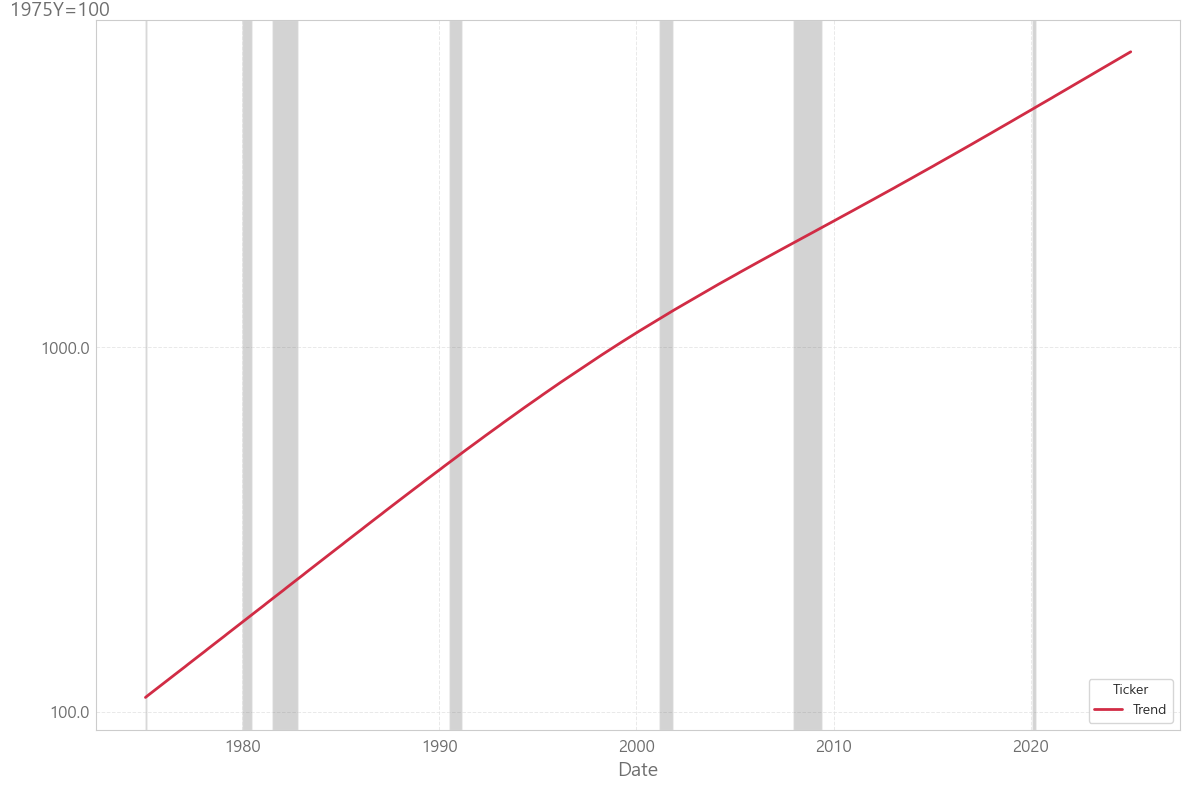

In [11]:
gm.trend_plot(np.exp(df_decomp[['S&P500', 'Trend']])*100, assets=['Trend'], colors=[mycolors['color_norm']], title=False)

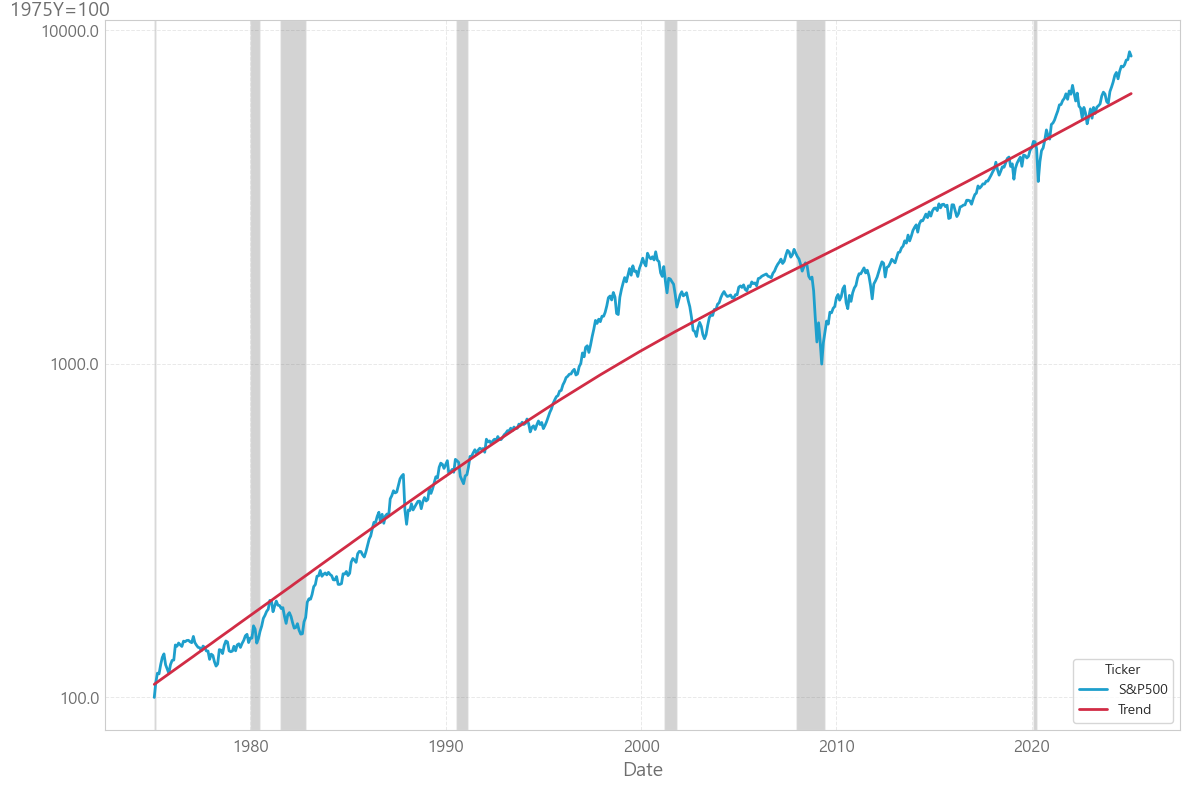

In [12]:
gm.trend_plot(np.exp(df_decomp[['S&P500', 'Trend']])*100, assets=['S&P500', 'Trend'], colors=[mycolors['color_cont'], mycolors['color_norm']], title=False)

In [13]:
data = cycle_df[['Cycle', 'Cyclical Component']].copy()

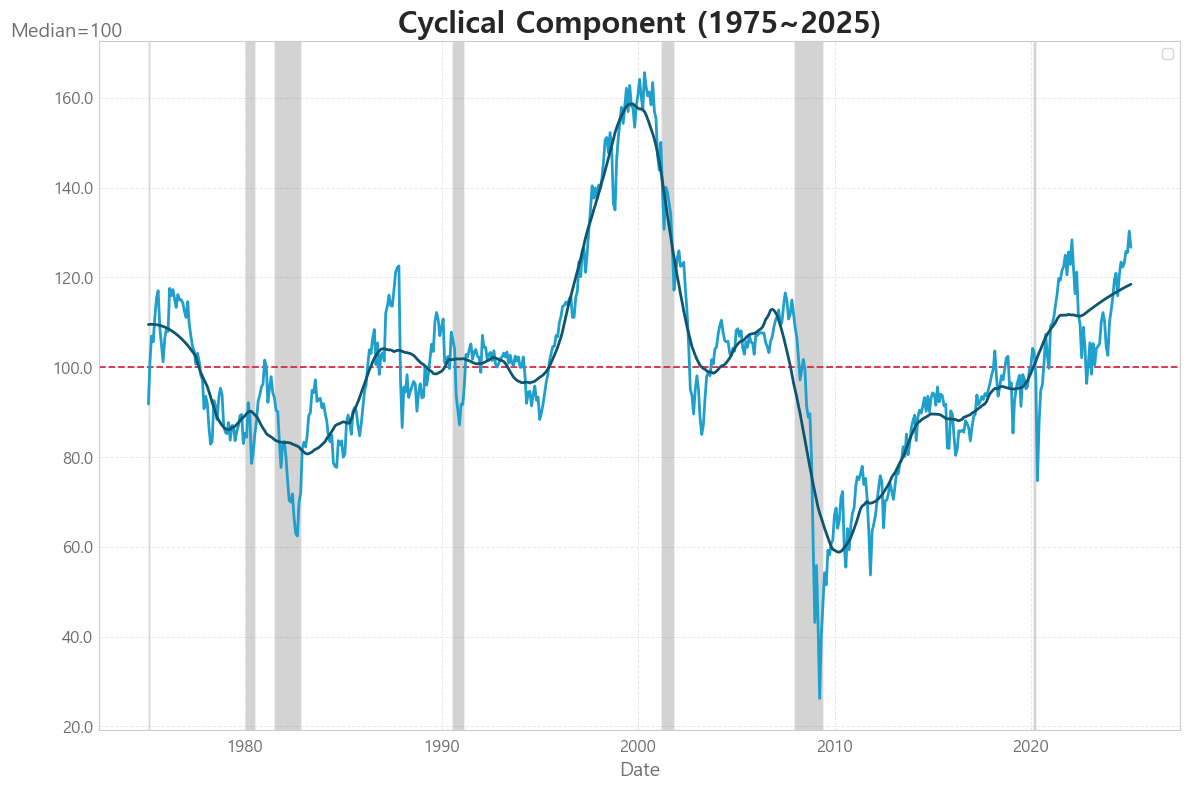

In [17]:
colors=[mycolors['color_cont'], mycolors['color_cont2']]
title=True
assets = ['Cyclical Component']

_df = data.reset_index()
_df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Values', value_name='Value')

# Use provided colors or default palette
if colors is None:
    colors = sns.color_palette('tab10', len(assets))


if title:
    plt.title(f'{", ".join(assets)} ({data.index[0].year}~{data.index[-1].year})', fontsize=22, fontweight='bold')
else:
    pass
plt.ylabel(f"Median=100", fontsize=14, labelpad=-50, loc="top", rotation=0, color=mycolors['color_around'])
plt.xlabel("Date", fontsize=14, color=mycolors['color_around'])
plt.xticks(fontsize=12, color=mycolors['color_around'])
plt.yticks(fontsize=12, color=mycolors['color_around'])
plt.axhline(100, color=mycolors['color_norm'], linewidth=1.3, linestyle='--')

# Adjust tick params
plt.gca().tick_params(axis="y", pad=1)

# Set y-axis to logarithmic scale

# Add grid
plt.grid(color=mycolors["color_around2"], linestyle="--", linewidth=0.7, alpha=0.7)
x_min, x_max = data.index.min(), data.index.max()
if highlight_periods:
    for start, end in highlight_periods:
        start_date = pd.to_datetime(start)
        end_date = pd.to_datetime(end)

        # Adjust highlight periods to fit within the x-axis range
        if start_date > x_max or end_date < x_min:
            continue
        adjusted_start = max(start_date, x_min)
        adjusted_end = min(end_date, x_max)
        plt.axvspan(adjusted_start, adjusted_end, facecolor=mycolors['color_around'], alpha=0.30)
        
# Convert x-axis to numeric format
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{round(y, 1)}'))

lineplot = sns.lineplot(data=_df, x='Date', y='Value', hue='Values', palette=colors, linestyle='-', linewidth=2)
plt.legend("")

# Show the plot
plt.tight_layout()
plt.show()